<a href="https://colab.research.google.com/github/MushRoomroom1/b/blob/main/HuggingPics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingPics 🤗🖼️

Fine-tune Vision Transformers for **anything** using images found on the web.

In [ ]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [2]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
#import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
#from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [3]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
print("Transformer model structure:",model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Transformer model structure: ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
    

In [8]:
from construct3DCNN import CNN3D

CNNmodel=CNN3D(num_classes=3)
CNNmodel=torch.load("try.pth")

<ipython-input-8-90a9a68f064d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNNmodel=torch.load("try.pth")


In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import ndimage
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, datas=None, labels=None, shape=None, input_D=None, input_H=None, input_W=None, phase='train', transforms=None):
        self.datas = datas
        self.labels = labels
        self.transforms = transforms
        self.shape = shape
        self.input_D = input_D
        self.input_H = input_H
        self.input_W = input_W
        self.phase = phase

    #返回整个数据集大小
    def __len__(self):
        return self.datas.shape[0]

    #根据索引index返回dataset[index]
    def __getitem__(self,index):
        if self.phase == 'train':
            #print(type(img), img.dtype)  # 检查数据类型
            img = self.__data_process__(self.datas[index])
            label = self.labels[index]
            #img = torch.tensor(img)
            img = torch.tensor(img, dtype=torch.float32)
            if self.transforms:
                img = self.transforms(img)
            return img,label
        elif self.phase == 'test':
            img = self.__data_process__(self.datas[index])
            img = torch.tensor(img)
            if self.transforms:
                img = self.transforms(img)
            return img

    def __itensity_normalize_one_volume__(self, volume):
        pixels = volume[volume > 0]
        mean = pixels.mean()
        std  = pixels.std()
        out = (volume - mean)/std
        out_random = np.random.normal(0, 1, size = volume.shape)
        out[volume == 0] = out_random[volume == 0]
        return out

    def __resize_data__(self, data):
        '''
        Resize the data to the input size
        '''
        if self.shape == 2:
            [depth, height, width] = data.shape
            scale = [self.input_D*1.0/depth, self.input_H*1.0/height, self.input_W*1.0/width]
        else:
            [channel, depth, height, width] = data.shape
            scale = [channel,self.input_D*1.0/depth, self.input_H*1.0/height, self.input_W*1.0/width]
        data = ndimage.zoom(data, scale, order=0)

        return data

    def __data_process__(self, data):

        # resize data
        data = self.__resize_data__(data)

        # normalization datas
        data = self.__itensity_normalize_one_volume__(data)

        return data

input_D = 79
input_H = 95
input_W = 79
train = h5py.File('/content/train_pre_data.h5','r')
labels = pd.read_csv('train_pre_label.csv')
features = np.array(train['data'])
#print('features.shape:',features.shape)   #(300, 1, 79, 95, 79)
X_train, X_val, y_train, y_val = train_test_split(features,labels['label'].values,test_size = 0.2,random_state = 42)
y_train = np.array(y_train, dtype=np.int64)  # 确保是 int64
y_val = np.array(y_val, dtype=np.int64)

y_train = torch.tensor(y_train, dtype=torch.long)  # 转换为 PyTorch Tensor
y_val = torch.tensor(y_val, dtype=torch.long)

train_datasets = MyDataset(datas=X_train,labels=y_train,shape=3,input_D=input_D,input_H=input_H,input_W=input_W,phase='train')
val_datasets = MyDataset(datas=X_val,labels=y_val,shape=3,input_D=input_D,input_H=input_H,input_W=input_W,phase='train')

train_loader = torch.utils.data.DataLoader(dataset=train_datasets, batch_size=30, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_datasets, batch_size=30, shuffle=False)

In [3]:
import h5py
import numpy as np
import os
print(os.getcwd())

temp_data_a = h5py.File('/content/testa.h5','r')['data'] #test_a和test_b中各有数据116例
temp_data_b = h5py.File('/content/testb.h5','r')['data']
temp_data = np.concatenate((np.array(temp_data_a),np.array(temp_data_b)))
print(temp_data.shape)   #(232, 1, 79, 95, 79)
print(temp_data_b.shape)   #(116, 1, 79, 95, 79)
len_temp_data_a = len(np.array(temp_data_a))
print(len_temp_data_a)  #116


/content
(232, 1, 79, 95, 79)
(116, 1, 79, 95, 79)
116


In [2]:
import torch
import torch.nn as nn
from transformers import ViTConfig, ViTModel
class ViT3DForClassification(nn.Module):
    def __init__(self, num_classes=3, pretrained_model="google/vit-base-patch16-224"):
        super(ViT3DForClassification, self).__init__()
        # 1. 加载预训练的 ViT
        self.vit = ViTModel.from_pretrained(pretrained_model)
        for param in self.vit.parameters():
          param.requires_grad = False
        # 2. 替换 2D Patch Embedding 为 3D Patch Embedding
        self.patch_embedding = nn.Conv3d(
            in_channels=1,  # 数据是单通道
            out_channels=768,
            kernel_size=(16, 16, 16),
            stride=(16, 16, 16)
        )
        # 3. 分类头
        self.classifier = nn.Linear(768, num_classes)
    def forward(self, x):
        batch_size, channels, depth, height, width = x.shape
        # 3D Patch 提取
        x = self.patch_embedding(x)  # (batch, 768, new_depth, new_height, new_width)
        # 调整形状，适配 ViT（转换为 2D）
        x = x.flatten(2).transpose(1, 2)  # (batch, num_patches, 768)
        # 传入 ViT Transformer（只用 Transformer 编码器）
        outputs = self.vit.encoder(x)
        cls_token = outputs.last_hidden_state[:, 0, :]  # 提取 CLS Token
        # 分类头
        x = self.classifier(cls_token)
        return x

# 测试
model = ViT3DForClassification(num_classes=3)
#dummy_input = torch.randn(2, 1, 79, 95, 79)  # 假设 batch_size=2
#output = model(dummy_input)
#print(output.shape)  # 预期 (2, 3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
#optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-3)
# 3、选择损失函数loss
loss_fn = nn.CrossEntropyLoss()

# 4、输入数据训练
epochs=30
logg=[]
early_stopping = 5
best_val_loss = float("inf")  # 初始化为无穷大
patience = 0
print("开始训练")
for epoch in range(epochs):
    train_acc=0
    train_loss=0
    for x,y_true in train_loader:
        optimizer.zero_grad()           #清空梯度
        y_pred = model(x)               #对x进行预测
        train_right=torch.argmax(y_pred, dim=1)
        train_acc+=(train_right==y_true).sum()
        loss = loss_fn(y_pred, y_true)  #计算误差
        train_loss+=loss.item()
        loss.backward()                 #将损失loss向输入侧进行反向传播
        optimizer.step()                #根据梯度更新网络参数;

    with torch.no_grad():               #避免反向传播时自动求导
        val_correct = 0
        val_loss=0
        for x, y_true in val_loader:   #这里是验证集，测试集只在最后用一次，不可能每个epoch都用的
            y_pred = model(x)           #是batch_size个列表, 每个数字表示概率
            val_loss+=loss_fn(y_pred,y_true).item()
            y_pred_class = torch.argmax(y_pred,dim=1)     #dim=1或-1表示取每一行的最大值的索引；dim=0或-2表示取每一列的最大值的索引；如果参数中不写dim，则得到的是张量中最大的值对应的索引（从0开始）。
            val_correct += torch.sum(y_pred_class == y_true).item()     #上一步选出概率最大的数字与该图片实际类别进行对比，相同就计数
    ta=train_acc/len(X_train)
    tl=train_loss/len(train_loader)
    accuracy=val_correct/len(X_val)
    vloss=val_loss/len(val_loader)
    info = dict()
    info['Epoch'] = epoch
    info['Train_acc'] = ta
    info['Train_loss'] = tl
    info['Validation_acc'] = accuracy
    info['Validation_loss'] = vloss
    logg.append(info)
    print(f"Epoch {epoch+1}, Train Accuracy: {ta:.3f} Train Loss: {tl:.3f}. Validation Accuracy: {accuracy:.3f}  Validation Loss: {vloss:.3f}")

    # 早停机制
    if vloss < best_val_loss:
        best_val_loss = vloss
        patience_counter = 0  # 重置计数器
        torch.save(model, 'best_model.pth')  # 保存当前最优模型
        print(f"Model is saved （with Validation Loss: {vloss:.3f}）")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping:
        print("触发早停机制！")
        break

#torch.save(model, 'final_model.pth')  # 训练结束后再存一个最终模型
print("训练结束，最佳模型保存在 'best_model.pth'")

#torch.save(model,'vit_clf.pth')

开始训练


<ipython-input-8-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)


Epoch 1, Train Accuracy: 0.658 Train Loss: 3.623. Validation Accuracy: 0.750  Validation Loss: 1.155
Model is saved （with Validation Loss: 1.155）
Epoch 2, Train Accuracy: 0.738 Train Loss: 0.902. Validation Accuracy: 0.817  Validation Loss: 0.448
Model is saved （with Validation Loss: 0.448）
Epoch 3, Train Accuracy: 0.788 Train Loss: 0.609. Validation Accuracy: 0.767  Validation Loss: 0.392
Model is saved （with Validation Loss: 0.392）
Epoch 4, Train Accuracy: 0.779 Train Loss: 0.753. Validation Accuracy: 0.817  Validation Loss: 1.149
Epoch 5, Train Accuracy: 0.808 Train Loss: 0.615. Validation Accuracy: 0.750  Validation Loss: 0.951
Epoch 6, Train Accuracy: 0.833 Train Loss: 0.496. Validation Accuracy: 0.750  Validation Loss: 0.625
Epoch 7, Train Accuracy: 0.875 Train Loss: 0.296. Validation Accuracy: 0.783  Validation Loss: 1.001
Epoch 8, Train Accuracy: 0.871 Train Loss: 0.522. Validation Accuracy: 0.833  Validation Loss: 1.743
触发早停机制！
训练结束，最佳模型保存在 'best_model.pth'


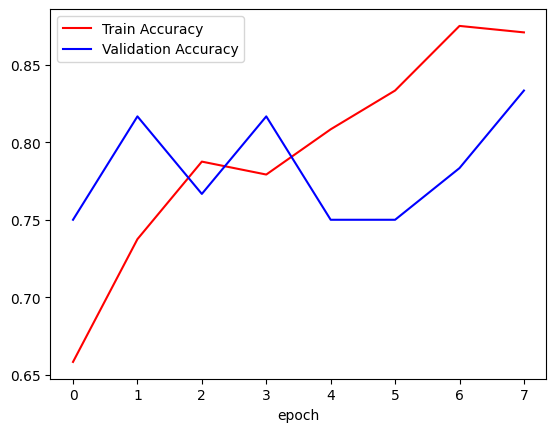

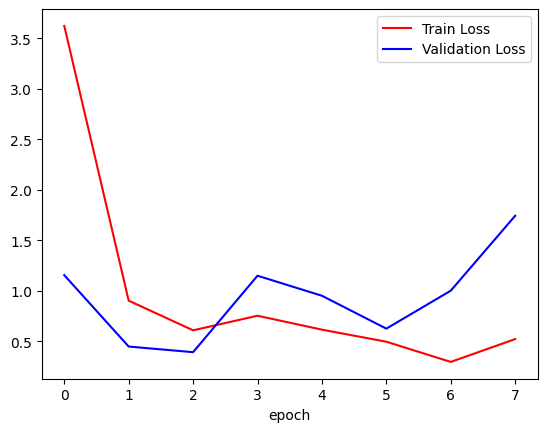

In [15]:
import matplotlib.pyplot as plt
def draw(logs: list):
    plt.figure()
    epoch = []
    loss = []
    acc = []
    vacc = []
    vloss = []
    for log_ in logs:
        epoch.append(log_['Epoch'])
        loss.append(log_['Train_loss'])
        acc.append(log_['Train_acc'])
        vacc.append(log_['Validation_acc'])
        vloss.append(log_['Validation_loss'])
    plt.plot(epoch, acc, 'r-', label='Train Accuracy')
    plt.plot(epoch, vacc, 'b-', label='Validation Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epoch, loss, 'r-', label='Train Loss')
    plt.plot(epoch, vloss, 'b-', label='Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

draw(logg)

In [9]:
def all_predict(test_dataloader,loadmodel,device,result_path):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    result_df = pd.DataFrame(columns=['testa_id','label'])     #生成一张表格

    with torch.no_grad():
        loadmodel.to(device)
        loadmodel.eval()
        for ii,image in enumerate(test_dataloader):
            image = image.to(device)
            output = loadmodel(image)
            _,indexs = torch.max(output.data,1)
            #indexs = np.squeeze(indexs.cpu().detach().numpy()).tolist()
            indexs = indexs.detach().cpu().numpy().tolist()
            indexs = indexs[0]  # 提取单一标签值
            #squeeze():将张量中维度为1的维度去掉  cpu():CPU计算  detach():阻止反向传播的梯度计算  numpy():tensor变量转numpy
            if ii < len_temp_data_a:
                result_df.loc[result_df.shape[0]] = [('testa_{}'.format(ii)),indexs]
            else:
                result_df.loc[result_df.shape[0]] = [('testb_{}'.format(ii - len_temp_data_a)),indexs]

            if ii%20==0:
                print('{} test data have been predicted'.format(ii))
                print('--'*20)
    result_df.to_csv(result_path,index=False)
    print('Result is saved')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
temp_data1 = np.array(temp_data, dtype=np.int64)  # 确保是 int64
temp_data = torch.tensor(temp_data1, dtype=torch.float32)  # 转换为 PyTorch Tensor
test_datasets = MyDataset(datas=temp_data,shape=3,input_D=input_D,input_H=input_H,input_W=input_W,phase='test')
test_loader = torch.utils.data.DataLoader(dataset=test_datasets)
model=torch.load("best_model.pth")
all_predict(test_dataloader=test_loader,loadmodel=model,device=device,result_path='C_to_T.csv')  #F1-score:0.63132
all_predict(test_dataloader=test_loader,loadmodel=CNNmodel,device=device,result_path='C.csv')   #F1-score:0.80923

<ipython-input-9-e6427c243a32>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load("best_model.pth")
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Pl

0 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

20 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

40 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

60 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

80 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

100 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

120 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

140 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

160 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

180 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

200 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

220 test data have been predicted
----------------------------------------


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)
<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  

Result is saved


<ipython-input-4-beecf7b113dc>:60: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = ndimage.interpolation.zoom(data, scale, order=0)


## Defining your search terms

Simply replace the terms in the widget below with whatever you want to classify, and we'll download ~150 images for each class for you.

You can define up to 5 classes. For < 5 classes, just leave the remaining text boxes blank.

### Examples

💡 If you need some inspiration, take a look at these examples:

|            | [nateraw/rare-puppers](https://huggingface.co/nateraw/rare-puppers) | [nateraw/pasta-pizza-ravioli](https://huggingface.co/nateraw/pasta-pizza-ravioli) | [nateraw/baseball-stadium-foods](https://huggingface.co/nateraw/baseball-stadium-foods) | [nateraw/denver-nyc-paris](https://huggingface.co/nateraw/denver-nyc-paris) |
| ---------- | ------------------------------------------------------------------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| **term_1** | samoyed                                                             | pizza                                                                             | cotton candy                                                                            | denver                                                                      |
| **term_2** | shiba inu                                                           | pasta                                                                             | hamburger                                                                               | new york city                                                               |
| **term_3** | corgi                                                               | ravioli                                                                           | hot dog                                                                                 | paris                                                                       |
| **term_4** |                                                                     |                                                                                   | nachos                                                                                  |                                                                             |
| **term_5** |                                                                     |                                                                                   | popcorn                                                                                 |                                                                             |



In [ ]:
term_1 = "samoyed" #@param {type:"string"}
term_2 = "shiba inu" #@param {type:"string"}
term_3 = "corgi" #@param {type:"string"}
term_4 = "" #@param {type:"string"}
term_5 = "" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5
])

search_terms = [x for x in search_terms if x.strip() != '']

## Get Images From The Web

Here, we loop over your selected search terms and collect ~150 related images for each.

We'll save them to a new folder named `images/` that is structured to work with [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder).

In [ ]:
SEARCH_URL = "https://huggingpics-api-server.fly.dev/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [ ]:
data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    urls = get_image_urls_by_term(search_term)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    urls_to_image_folder(urls, search_term_dir)

## Init Dataset and Split into Training and Validation Sets


In [ ]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Show Some Examples

#### ⚠️ Note - The image search API isn't perfect ⚠️

You may need to go back, tweak your search terms, and repeat the cells above until the images shown below look good.

A few bad images is OK, but if they are completely incorrect, you'll definitely want to try again with different terms.

In [ ]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [ ]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

## Init Feature Extractor, Model, Data Loaders


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

## Check if it Worked 😅

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

# Push to 🤗 Hub 🚀

You'll need to authenticate with your Hugging Face account, so make sure to [sign up](https://huggingface.co/join) if you haven't already.

Your repo will be created at `{hf_username}/{model_id}`, so pick a `model_id` you like 😊

In [ ]:
notebook_login()

In [ ]:
model_id = "rare-puppers" #@param {type:"string"}

description = """
Autogenerated by HuggingPics🤗🖼️

Create your own image classifier for **anything** by running [the demo on Google Colab](https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb).

Report any issues with the demo at the [github repo](https://github.com/nateraw/huggingpics).
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )


# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")